# Medical Abstract Classification with Federated Learning




This is federated learning course project code. We are going to work with medical text abstracts describing medical conditions.

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, log_loss
import networkx as nx
import torch
from tqdm.auto import tqdm
from transformers import AutoModel, AutoTokenizer

In [14]:
df_train = pd.read_csv('https://raw.githubusercontent.com/sebischair/Medical-Abstracts-TC-Corpus/main/medical_tc_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/sebischair/Medical-Abstracts-TC-Corpus/main/medical_tc_test.csv')

In [15]:
df_train = df_train[df_train['condition_label'].isin([1, 2])].sample(2000, random_state=15)
df_test = df_test[df_test['condition_label'].isin([1, 2])].sample(100, random_state=15)

In [16]:
df_train.replace({2:0}, inplace=True)
df_test.replace({2:0}, inplace=True)

In [17]:
df_train.head()

,condition_label,medical_abstract
8456,1,Partial duplication of the face: case report a...
2831,1,The t(1;19)(q23;p13) results in consistent fus...
1784,1,Retroviral transduction of protein kinase C-ga...
9307,1,Vascular abnormalities in epidermal nevus synd...
8875,1,Skull base malignancy following long-term sinu...


Let's see how one sample document looks like

In [18]:
df_train.iloc[0].medical_abstract

'Partial duplication of the face: case report and review. Complete or partial facial duplication is a rare congenital malformation. A spectrum of structural abnormalities varying in degrees of severity has been described in affected individuals. We present discordance for facial duplication between monozygotic twins in which maxillary and mandibular duplication was present in one. The involved twin showed the following findings: ocular hypertelorism, bifidity of the nose, duplication of the maxilla, macrostomia, cleft of the lower lip, hamartoma of the vomer, supernumerary teeth, duplication of the mandibular teeth, bifidity of the tongue, and hamartoma of the floor of the mouth. Surgical management of the facial anomalies is discussed. A review of the literature and discussion of this rare malformation are presented. '

Now let's calculate train and test statistics

In [19]:
df_train['condition_label'].value_counts()

condition_label
1    1354
0     646
Name: count, dtype: int64

In [20]:
df_test['condition_label'].value_counts()

condition_label
1    69
0    31
Name: count, dtype: int64

In [21]:
train_values = df_train.values
train_local = np.array_split(train_values, 5)
test_values = df_test.values

## Helper functions

In [22]:
def extract_features(text):
    # The function takes text as an input and transforms it
    # into dense feature vector by applying transformer model.
    # It returns pooled output.
    features = tokenizer.encode_plus(
                                      text,
                                      add_special_tokens=True,
                                      max_length=512,
                                      truncation=True,
                                      return_tensors='pt',
                                      return_attention_mask=True
                                      )
    with torch.no_grad():
        outputs = model(features['input_ids'], features['attention_mask'])
    pooler_output = outputs[1]
    return pooler_output.detach().numpy()

In [23]:
def transform_data(dataset):
    # The function transforms labels and features into needed format
    labels = [i[0] for i in dataset]
    features = [extract_features(i[1])[0] for i in dataset]
    return np.array(features), np.array(labels).reshape((-1, 1))

## FedSGD

In [24]:
def sigmoid(a):
    return 1.0 / (1 + np.exp(-a))

def train_FedSGD(max_iter = 1000, alpha = 0.5, l_rate = 0.01, batch_size = 10):
    for i in range(max_iter):
        # Iterate over all nodes.
        for current_node in G_FMI.nodes:

            # Extract the training data from the current node.
            X_train = G_FMI.nodes[current_node]['X_train']
            y_train = G_FMI.nodes[current_node]['y_train']
            w_current = G_FMI.nodes[current_node]['weights']
            training_size = len(y_train)

            # Compute the first term of the Equation 5.11.

            curr_batch_start = G_FMI.nodes[current_node]['curr_batch_start']

            # Get the batched features and labels
            X_train_batch = X_train[curr_batch_start:(curr_batch_start+batch_size)]
            y_train_batch = y_train[curr_batch_start:(curr_batch_start+batch_size)]

            # update batch start for the next iteration
            curr_batch_start = curr_batch_start + batch_size
            # check if batch start would be outside the training set
            if curr_batch_start >= training_size:
                curr_batch_start = 0  # if next batch exceeds training set size start over from first datapoint
            G_FMI.nodes[current_node]['curr_batch_start']= curr_batch_start

            # logistic regression step
            term_1 = (1/batch_size) * X_train_batch.T.dot(y_train_batch - sigmoid(X_train_batch.dot(w_current)))


            term_2 = 0
            neighbors = list(G_FMI.neighbors(current_node))
            for neighbor in neighbors:
                w_neighbor = G_FMI.nodes[neighbor]['weights']
                term_2 += w_neighbor - w_current
            term_2 *= 2*alpha
            # Equation 5.11
            w_updated = w_current + l_rate * (term_1 + term_2)

            # Update the current weight vector but do not overwrite the
            # "weights" attribute as we need to do all updates synchronously, i.e.,
            # using the previous local params

            G_FMI.nodes[current_node]['newweights'] = w_updated

        # after computing the new localparmas for each node, we now update
        # the node attribute 'weights' for all nodes
        for node_id in G_FMI.nodes:
            G_FMI.nodes[node_id]['weights'] = G_FMI.nodes[node_id]['newweights']

## FedAvg

In [25]:
def train_FedAVG(max_iter = 1000, l_rate = 0.01, batch_size = 10):
    for i in range(max_iter):
        # Iterate over all nodes.
        for current_node in G_FMI.nodes:

            # Extract the training data from the current node.
            X_train = G_FMI.nodes[current_node]['X_train']
            y_train = G_FMI.nodes[current_node]['y_train']
            w_current = G_FMI.nodes[current_node]['weights']
            training_size = len(y_train)

            curr_batch_start = G_FMI.nodes[current_node]['curr_batch_start']

            # Get the batched features and labels
            X_train_batch = X_train[curr_batch_start:(curr_batch_start+batch_size)]
            y_train_batch = y_train[curr_batch_start:(curr_batch_start+batch_size)]

            # update batch start for the next iteration
            curr_batch_start = curr_batch_start + batch_size
            # check if batch start would be outside the training set
            if curr_batch_start >= training_size:
                curr_batch_start = 0  # if next batch exceeds training set size start over from first datapoint
            G_FMI.nodes[current_node]['curr_batch_start']= curr_batch_start

            term_1 = (1/batch_size) * X_train_batch.T.dot(y_train_batch - sigmoid(X_train_batch.dot(w_current)))
            w_updated = w_current + l_rate * term_1

            # Update the current weight vector but do not overwrite the
            # "weights" attribute as we need to do all updates synchronously, i.e.,
            # using the previous local params

            G_FMI.nodes[current_node]['newweights'] = w_updated

        # after computing the new localparmas for each node, we now update
        # the node attribute 'weights' for all nodes as an averge
        # of all weights of local models
        main_model = np.zeros_like(G_FMI.nodes[current_node]['newweights'])
        for node_id in G_FMI.nodes:
            main_model += G_FMI.nodes[current_node]['newweights']
        main_model /= 5
        for node_id in G_FMI.nodes:
            G_FMI.nodes[node_id]['weights'] = main_model.copy()

## Evaluation Function

In [26]:
def evaluate():
    train_errors = np.zeros(5)
    val_errors = np.zeros(5)
    test_errors = np.zeros(5)

    # Iterate over all nodes.
    for station in G_FMI.nodes:
        # Extract the data of the current node.
        X_train = G_FMI.nodes[station]['X_train']
        y_train = G_FMI.nodes[station]['y_train']
        X_val = G_FMI.nodes[station]['X_val']
        y_val = G_FMI.nodes[station]['y_val']
        X_test = G_FMI.nodes[station]['X_test']
        y_test = G_FMI.nodes[station]['y_test']
        w = G_FMI.nodes[station]['weights']

        # Compute and store the training and validation loss and test f-score.
        train_errors[station] = log_loss(y_train, sigmoid(X_train.dot(w)))
        val_errors[station] = log_loss(y_val, sigmoid(X_val.dot(w)))
        test_errors[station] = f1_score(y_test, np.round(sigmoid(X_test.dot(w))))

    # Output the average training and validation errors.
    print("The average training log_loss:", np.mean(train_errors))
    print("The average validation log_loss:", np.mean(val_errors))
    print("The average test f1:", np.mean(test_errors))
    print("All models test f1:", *test_errors)

## Experiments with feature extraction

We will try out 3 methods of feature extraction:
- BERT
- BioBERT
- Tf-Idf

### BERT

In [27]:
model = AutoModel.from_pretrained("prajjwal1/bert-tiny")
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [28]:
# Create a networkX graph
G_FMI = nx.Graph()

# Add a one node per station
G_FMI.add_nodes_from(range(0, 5))

X_test, y_test = transform_data(test_values)

for i, train_local_data in tqdm(enumerate(train_local), total=5):
    # Extract data of a certain station
    # Extract features and labels, do train and validation split
    train, val = train_test_split(train_local_data, test_size=0.3, random_state=42)
    X_train, y_train = transform_data(train)
    X_val, y_val = transform_data(val)

    G_FMI.nodes[i]['id'] = i # The name of the i-th weather station
    G_FMI.nodes[i]['X_train'] = X_train # The feature matrix for local dataset at node i
    G_FMI.nodes[i]['y_train'] = y_train  # The label vector for local dataset at node i
    G_FMI.nodes[i]['X_val'] = X_val # The feature matrix for local val dataset at node i
    G_FMI.nodes[i]['y_val'] = y_val  # The label vector for local val dataset at node i
    G_FMI.nodes[i]['X_test'] = X_test
    G_FMI.nodes[i]['y_test'] = y_test

  0%|          | 0/5 [00:00<?, ?it/s]

**FedSGD**

In [29]:
for a in [0.01, 0.1, 0.5, 0.7]:
    for station in G_FMI.nodes:
      G_FMI.nodes[station]['weights'] = np.zeros((G_FMI.nodes[station]['X_train'].shape[1], 1))   #
      G_FMI.nodes[station]['curr_batch_start'] = 0
    train_FedSGD(l_rate=a)
    evaluate()

The average training log_loss: 0.5189232043386116
The average validation log_loss: 0.5528011467957029
The average test f1: 0.8300834078306101
All models test f1: 0.8214285714285715 0.8322981366459627 0.8271604938271604 0.8481012658227848 0.8214285714285715
The average training log_loss: 0.40154644052332233
The average validation log_loss: 0.48334551497450207
The average test f1: 0.8243524634514596
All models test f1: 0.8205128205128205 0.8211920529801324 0.8476821192052981 0.8104575163398693 0.821917808219178
The average training log_loss: 0.4985683104117594
The average validation log_loss: 0.7867600773096365
The average test f1: 0.8075142538177941
All models test f1: 0.7947019867549668 0.7916666666666667 0.8057553956834532 0.8235294117647057 0.821917808219178
The average training log_loss: 0.6331275123772286
The average validation log_loss: 1.0821700245738264
The average test f1: 0.8193935391476652
All models test f1: 0.7973856209150327 0.8079470198675496 0.8260869565217391 0.83221476

**FedAvg**

In [30]:
for a in [0.01, 0.1, 0.5, 0.7]:
    for station in G_FMI.nodes:
      G_FMI.nodes[station]['weights'] = np.zeros((G_FMI.nodes[station]['X_train'].shape[1], 1))   #
      G_FMI.nodes[station]['curr_batch_start'] = 0
    train_FedAVG(l_rate=a)
    evaluate()

The average training log_loss: 0.5570955559295798
The average validation log_loss: 0.5563740507637048
The average test f1: 0.8214285714285715
All models test f1: 0.8214285714285715 0.8214285714285715 0.8214285714285715 0.8214285714285715 0.8214285714285715
The average training log_loss: 0.4932410892931703
The average validation log_loss: 0.4880978733430254
The average test f1: 0.821917808219178
All models test f1: 0.821917808219178 0.821917808219178 0.821917808219178 0.821917808219178 0.821917808219178
The average training log_loss: 0.740916540985347
The average validation log_loss: 0.7416597209156517
The average test f1: 0.821917808219178
All models test f1: 0.821917808219178 0.821917808219178 0.821917808219178 0.821917808219178 0.821917808219178
The average training log_loss: 0.9213592526097394
The average validation log_loss: 0.9279445912836792
The average test f1: 0.8333333333333333
All models test f1: 0.8333333333333333 0.8333333333333333 0.8333333333333333 0.8333333333333333 0.83

FedAvg and FedSGD perform similarly for this method

### BioBERT

In [31]:
model = AutoModel.from_pretrained("nlpie/tiny-biobert")
tokenizer = AutoTokenizer.from_pretrained("nlpie/tiny-biobert")

config.json:   0%|          | 0.00/840 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/55.6M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at nlpie/tiny-biobert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [32]:
# Create a networkX graph
G_FMI = nx.Graph()

# Add a one node per station
G_FMI.add_nodes_from(range(0, 5))
X_test, y_test = transform_data(test_values)

for i, train_local_data in tqdm(enumerate(train_local), total=5):
    # Extract data of a certain station
    # Extract features and labels, do train and validation split
    train, val = train_test_split(train_local_data, test_size=0.3, random_state=42)
    X_train, y_train = transform_data(train)
    X_val, y_val = transform_data(val)

    G_FMI.nodes[i]['id'] = i # The name of the i-th weather station
    G_FMI.nodes[i]['X_train'] = X_train # The feature matrix for local dataset at node i
    G_FMI.nodes[i]['y_train'] = y_train  # The  label vector for local dataset at node i
    G_FMI.nodes[i]['X_val'] = X_val # The feature matrix for local val dataset at node i
    G_FMI.nodes[i]['y_val'] = y_val  # The  label vector for local val dataset at node i
    G_FMI.nodes[i]['X_test'] = X_test
    G_FMI.nodes[i]['y_test'] = y_test

  0%|          | 0/5 [00:00<?, ?it/s]

**FedSGD**

In [33]:
for a in [0.01, 0.1, 0.5, 0.7]:
    for station in G_FMI.nodes:
      G_FMI.nodes[station]['weights'] = np.zeros((G_FMI.nodes[station]['X_train'].shape[1], 1))
      G_FMI.nodes[station]['curr_batch_start'] = 0
    train_FedSGD(max_iter = 1000, l_rate=a, batch_size = 10)
    evaluate()

The average training log_loss: 0.6141240127778451
The average validation log_loss: 0.6194321020052513
The average test f1: 0.8165680473372781
All models test f1: 0.8165680473372781 0.8165680473372781 0.8165680473372781 0.8165680473372781 0.8165680473372781
The average training log_loss: 0.5382220883279485
The average validation log_loss: 0.5467087212218995
The average test f1: 0.8166507851123235
All models test f1: 0.8165680473372781 0.8214285714285715 0.8165680473372781 0.812121212121212 0.8165680473372781
The average training log_loss: 0.41768237491075216
The average validation log_loss: 0.4256205644714247
The average test f1: 0.8329540637223658
All models test f1: 0.8313253012048193 0.8211920529801324 0.8363636363636363 0.84472049689441 0.8311688311688311
The average training log_loss: 0.3970823498092241
The average validation log_loss: 0.4050463996450637
The average test f1: 0.8346246495642191
All models test f1: 0.8313253012048193 0.8266666666666668 0.8414634146341463 0.8447204968

**FedAvg**

In [34]:
for a in [0.01, 0.1, 0.5, 0.7]:
    for station in G_FMI.nodes:
      G_FMI.nodes[station]['weights'] = np.zeros((G_FMI.nodes[station]['X_train'].shape[1], 1))   #
      G_FMI.nodes[station]['curr_batch_start'] = 0
    train_FedAVG(l_rate=a)
    evaluate()

The average training log_loss: 0.623613638992327
The average validation log_loss: 0.6198595989163145
The average test f1: 0.8165680473372781
All models test f1: 0.8165680473372781 0.8165680473372781 0.8165680473372781 0.8165680473372781 0.8165680473372781
The average training log_loss: 0.5567010780250141
The average validation log_loss: 0.5460844959640612
The average test f1: 0.8165680473372781
All models test f1: 0.8165680473372781 0.8165680473372781 0.8165680473372781 0.8165680473372781 0.8165680473372781
The average training log_loss: 0.4324105284031633
The average validation log_loss: 0.4151403584948626
The average test f1: 0.8311688311688311
All models test f1: 0.8311688311688311 0.8311688311688311 0.8311688311688311 0.8311688311688311 0.8311688311688311
The average training log_loss: 0.40919749139030503
The average validation log_loss: 0.38928127080053443
The average test f1: 0.8289473684210528
All models test f1: 0.8289473684210527 0.8289473684210527 0.8289473684210527 0.8289473

Both algorithm give similar results

### Tf-Idf

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
# Create a networkX graph
G_FMI = nx.Graph()
tfidfvectorizer = TfidfVectorizer(analyzer='word', stop_words= 'english', max_features=100000)

# Add a one node per station
G_FMI.add_nodes_from(range(0, 5))

train_sets = []
train_labels = []
for i, train_local_data in tqdm(enumerate(train_local), total=5):
    # Extract data of a certain station
    # Extract features and labels
    train, val = train_test_split(train_local_data, test_size=0.3, random_state=42)
    X_train = [i[1] for i in train]
    y_train = [i[0] for i in train]
    train_sets.extend(X_train)
    train_labels.extend(y_train)

tfidfvectorizer.fit(train_sets)
X_test = [i[1] for i in test_values]
X_test = tfidfvectorizer.transform(X_test).toarray()
y_test = [i[0] for i in test_values]


for i, train_local_data in tqdm(enumerate(train_local), total=5):
    # Extract data of a certain station
    # Extract features and labels, do train and validation split
    train, val = train_test_split(train_local_data, test_size=0.3, random_state=42)
    X_train = [i[1] for i in train]
    X_train = tfidfvectorizer.transform(X_train).toarray()
    X_val = [i[1] for i in val]
    X_val = tfidfvectorizer.transform(X_val).toarray()
    y_train = [i[0] for i in train]
    y_val = [i[0] for i in val]



    G_FMI.nodes[i]['id'] = i # The name of the i-th weather station
    G_FMI.nodes[i]['X_train'] = X_train # The feature matrix for local dataset at node i
    G_FMI.nodes[i]['y_train'] = np.array(y_train).reshape((-1, 1))  # The  label vector for local dataset at node i
    G_FMI.nodes[i]['X_val'] = X_val # The feature matrix for local val dataset at node i
    G_FMI.nodes[i]['y_val'] = np.array(y_val).reshape((-1, 1))  # The  label vector for local val dataset at node i
    G_FMI.nodes[i]['X_test'] = X_test
    G_FMI.nodes[i]['y_test'] = np.array(y_test).reshape((-1, 1))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

**FedSGD**

In [37]:
for a in [0.01, 0.1, 0.5, 0.7]:
    for station in G_FMI.nodes:
      G_FMI.nodes[station]['weights'] = np.zeros((G_FMI.nodes[station]['X_train'].shape[1], 1))   #
      G_FMI.nodes[station]['curr_batch_start'] = 0
    train_FedSGD(max_iter=1000, l_rate=a, batch_size=10)
    evaluate()

The average training log_loss: 0.672309878095527
The average validation log_loss: 0.6801681225834562
The average test f1: 0.8295277097872094
All models test f1: 0.8165680473372781 0.8313253012048193 0.8313253012048193 0.8518518518518519 0.8165680473372781
The average training log_loss: 0.5350986880800421
The average validation log_loss: 0.598895916789099
The average test f1: 0.8387009068463623
All models test f1: 0.8165680473372781 0.8466257668711656 0.8414634146341463 0.8624999999999999 0.8263473053892215
The average training log_loss: 0.28953912345995036
The average validation log_loss: 0.47182272394802444
The average test f1: 0.8803118730922483
All models test f1: 0.8679245283018869 0.8734177215189874 0.8903225806451612 0.912751677852349 0.8571428571428571
The average training log_loss: 0.23397255876580642
The average validation log_loss: 0.444475773754916
The average test f1: 0.8949597120425871
All models test f1: 0.8789808917197451 0.8903225806451612 0.9019607843137255 0.918918918

**FedAvg**

In [38]:
for a in [0.01, 0.1, 0.5, 0.7]:
    for station in G_FMI.nodes:
      G_FMI.nodes[station]['weights'] = np.zeros((G_FMI.nodes[station]['X_train'].shape[1], 1))   #
      G_FMI.nodes[station]['curr_batch_start'] = 0
    train_FedAVG(l_rate=a)
    evaluate()

The average training log_loss: 0.6775467431448041
The average validation log_loss: 0.6784275798433336
The average test f1: 0.8165680473372781
All models test f1: 0.8165680473372781 0.8165680473372781 0.8165680473372781 0.8165680473372781 0.8165680473372781
The average training log_loss: 0.584202156292927
The average validation log_loss: 0.5920257390415211
The average test f1: 0.8263473053892214
All models test f1: 0.8263473053892215 0.8263473053892215 0.8263473053892215 0.8263473053892215 0.8263473053892215
The average training log_loss: 0.445869561039174
The average validation log_loss: 0.4721157404170987
The average test f1: 0.8571428571428571
All models test f1: 0.8571428571428571 0.8571428571428571 0.8571428571428571 0.8571428571428571 0.8571428571428571
The average training log_loss: 0.4152282451752568
The average validation log_loss: 0.44640911520471266
The average test f1: 0.8846153846153847
All models test f1: 0.8846153846153846 0.8846153846153846 0.8846153846153846 0.884615384

FedSGD is slightly better compared to FedAvg

## Comparison with models trained without federated learning

Let's now train separate models on local train datasets and evaluate them on test data. For this part we will use the best learning rate found in the previous calculation

### Tf-Idf

In [39]:
def train_separate(max_iter = 1000, l_rate = 0.01, batch_size = 10):
    # for each node train the model
    for current_node in G_FMI.nodes:
        for i in range(max_iter):

            # Extract the training data from the current node.
            X_train = G_FMI.nodes[current_node]['X_train']
            y_train = G_FMI.nodes[current_node]['y_train']
            w_current = G_FMI.nodes[current_node]['weights']
            training_size = len(y_train)

            # Compute the first term of the Equation 5.11.

            curr_batch_start = G_FMI.nodes[current_node]['curr_batch_start']
            # Get the batched features and labels
            X_train_batch = X_train[curr_batch_start:(curr_batch_start+batch_size)]
            y_train_batch = y_train[curr_batch_start:(curr_batch_start+batch_size)]

            # update batch start for the next iteration
            curr_batch_start = curr_batch_start + batch_size
            # check if batch start would be outside the training set
            if curr_batch_start >= training_size:
                curr_batch_start = 0  # if next batch exceeds training set size start over from first datapoint
            G_FMI.nodes[current_node]['curr_batch_start']= curr_batch_start

            term_1 = (1/batch_size) * X_train_batch.T.dot(y_train_batch - sigmoid(X_train_batch.dot(w_current)))


            w_updated = w_current + l_rate * term_1
            G_FMI.nodes[current_node]['weights'] = w_updated

In [40]:
for station in G_FMI.nodes:
    G_FMI.nodes[station]['weights'] = np.zeros((G_FMI.nodes[station]['X_train'].shape[1], 1))   #
    G_FMI.nodes[station]['curr_batch_start'] = 0

In [41]:
train_separate(l_rate=0.7)
evaluate()

The average training log_loss: 0.23397255876580642
The average validation log_loss: 0.444475773754916
The average test f1: 0.8949597120425871
All models test f1: 0.8789808917197451 0.8903225806451612 0.9019607843137255 0.918918918918919 0.8846153846153846


As the best approach for Federated Learning is FedSGD with $lr = 0.7$ and TF-IDF as feature extraction method. Let's calculate validation and train errors for each local dataset.

In [42]:
# Create a networkX graph
G_FMI = nx.Graph()
tfidfvectorizer = TfidfVectorizer(analyzer='word', stop_words= 'english', max_features=100000)

# Add a one node per station
G_FMI.add_nodes_from(range(0, 5))

train_sets = []
train_labels = []
for i, train_local_data in tqdm(enumerate(train_local), total=5):
    # Extract data of a certain station
    # Extract features and labels
    train, val = train_test_split(train_local_data, test_size=0.3, random_state=42)
    X_train = [i[1] for i in train]
    y_train = [i[0] for i in train]
    train_sets.extend(X_train)
    train_labels.extend(y_train)

tfidfvectorizer.fit(train_sets)
X_test = [i[1] for i in test_values]
X_test = tfidfvectorizer.transform(X_test).toarray()
y_test = [i[0] for i in test_values]


for i, train_local_data in tqdm(enumerate(train_local), total=5):
    # Extract data of a certain station
    # Extract features and labels
    train, val = train_test_split(train_local_data, test_size=0.3, random_state=42)
    X_train = [i[1] for i in train]
    X_train = tfidfvectorizer.transform(X_train).toarray()
    X_val = [i[1] for i in val]
    X_val = tfidfvectorizer.transform(X_val).toarray()
    y_train = [i[0] for i in train]
    y_val = [i[0] for i in val]



    G_FMI.nodes[i]['id'] = i # The name of the i-th weather station
    G_FMI.nodes[i]['X_train'] = X_train # The feature matrix for local dataset at node i
    G_FMI.nodes[i]['y_train'] = np.array(y_train).reshape((-1, 1))  # The  label vector for local dataset at node i
    G_FMI.nodes[i]['X_val'] = X_val # The feature matrix for local val dataset at node i
    G_FMI.nodes[i]['y_val'] = np.array(y_val).reshape((-1, 1))  # The  label vector for local val dataset at node i
    G_FMI.nodes[i]['X_test'] = X_test
    G_FMI.nodes[i]['y_test'] = np.array(y_test).reshape((-1, 1))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [43]:
for station in G_FMI.nodes:
    G_FMI.nodes[station]['weights'] = np.zeros((G_FMI.nodes[station]['X_train'].shape[1], 1))   #
    G_FMI.nodes[station]['curr_batch_start'] = 0

In [44]:
train_FedSGD(max_iter = 1000, l_rate = 0.7, batch_size = 10)

In [45]:
train_errors = np.zeros(5)
val_errors = np.zeros(5)

# Iterate over all nodes.
for station in G_FMI.nodes:
    # Extract the data of the current node.
    X_train = G_FMI.nodes[station]['X_train']
    y_train = G_FMI.nodes[station]['y_train']
    X_val = G_FMI.nodes[station]['X_val']
    y_val = G_FMI.nodes[station]['y_val']
    w = G_FMI.nodes[station]['weights']

    # Compute and store the training and validation loss and test f-score.
    train_errors[station] = log_loss(y_train, sigmoid(X_train.dot(w)))
    val_errors[station] = log_loss(y_val, sigmoid(X_val.dot(w)))

# Output the average training and validation errors.
print("All nodes training log_loss:", *train_errors)
print("All nodes validation log_loss:", *val_errors)

All nodes training log_loss: 0.22733581534342356 0.23878460412495792 0.24692779172353013 0.23832148727810362 0.21849309535901668
All nodes validation log_loss: 0.452834945189316 0.4216992667020362 0.4645727273166155 0.4572701086989526 0.42600182086765975


### BioBERT

In [46]:
model = AutoModel.from_pretrained("nlpie/tiny-biobert")
tokenizer = AutoTokenizer.from_pretrained("nlpie/tiny-biobert")

Some weights of BertModel were not initialized from the model checkpoint at nlpie/tiny-biobert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
# Create a networkX graph
G_FMI = nx.Graph()

# Add a one node per station
G_FMI.add_nodes_from(range(0, 5))
X_test, y_test = transform_data(test_values)

for i, train_local_data in tqdm(enumerate(train_local), total=5):
    # Extract data of a certain station
    # Extract features and labels
    train, val = train_test_split(train_local_data, test_size=0.3, random_state=42)
    X_train, y_train = transform_data(train)
    X_val, y_val = transform_data(val)

    G_FMI.nodes[i]['id'] = i # The name of the i-th weather station
    G_FMI.nodes[i]['X_train'] = X_train # The feature matrix for local dataset at node i
    G_FMI.nodes[i]['y_train'] = y_train  # The  label vector for local dataset at node i
    G_FMI.nodes[i]['X_val'] = X_val # The feature matrix for local val dataset at node i
    G_FMI.nodes[i]['y_val'] = y_val  # The  label vector for local val dataset at node i
    G_FMI.nodes[i]['X_test'] = X_test
    G_FMI.nodes[i]['y_test'] = y_test

  0%|          | 0/5 [00:00<?, ?it/s]

In [48]:
for station in G_FMI.nodes:
    G_FMI.nodes[station]['weights'] = np.zeros((G_FMI.nodes[station]['X_train'].shape[1], 1))   #
    G_FMI.nodes[station]['curr_batch_start'] = 0

In [49]:
train_separate(l_rate=0.7)
evaluate()

The average training log_loss: 0.3990823463569332
The average validation log_loss: 0.4035211423145646
The average test f1: 0.8332825974606333
All models test f1: 0.8313253012048193 0.8211920529801324 0.8414634146341463 0.8466257668711656 0.8258064516129032


### BERT

In [50]:
model = AutoModel.from_pretrained("prajjwal1/bert-tiny")
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [51]:
# Create a networkX graph
G_FMI = nx.Graph()

# Add a one node per station
G_FMI.add_nodes_from(range(0, 5))

X_test, y_test = transform_data(test_values)

for i, train_local_data in tqdm(enumerate(train_local), total=5):
    # Extract data of a certain station
    # Extract features and labels
    train, val = train_test_split(train_local_data, test_size=0.3, random_state=42)
    X_train, y_train = transform_data(train)
    X_val, y_val = transform_data(val)

    G_FMI.nodes[i]['id'] = i # The name of the i-th weather station
    G_FMI.nodes[i]['X_train'] = X_train # The feature matrix for local dataset at node i
    G_FMI.nodes[i]['y_train'] = y_train  # The label vector for local dataset at node i
    G_FMI.nodes[i]['X_val'] = X_val # The feature matrix for local val dataset at node i
    G_FMI.nodes[i]['y_val'] = y_val  # The label vector for local val dataset at node i
    G_FMI.nodes[i]['X_test'] = X_test
    G_FMI.nodes[i]['y_test'] = y_test

  0%|          | 0/5 [00:00<?, ?it/s]

In [52]:
for station in G_FMI.nodes:
    G_FMI.nodes[station]['weights'] = np.zeros((G_FMI.nodes[station]['X_train'].shape[1], 1))   #
    G_FMI.nodes[station]['curr_batch_start'] = 0

In [53]:
train_separate(l_rate=0.1)
evaluate()

The average training log_loss: 0.40154644052332233
The average validation log_loss: 0.48334551497450207
The average test f1: 0.8243524634514596
All models test f1: 0.8205128205128205 0.8211920529801324 0.8476821192052981 0.8104575163398693 0.821917808219178


In [54]:
for station in G_FMI.nodes:
    G_FMI.nodes[station]['weights'] = np.zeros((G_FMI.nodes[station]['X_train'].shape[1], 1))   #
    G_FMI.nodes[station]['curr_batch_start'] = 0

In [55]:
train_FedSGD(max_iter = 1000, l_rate = 0.7, batch_size = 10)

In [56]:
train_errors = np.zeros(5)
val_errors = np.zeros(5)

# Iterate over all nodes.
for station in G_FMI.nodes:
    # Extract the data of the current node.
    X_train = G_FMI.nodes[station]['X_train']
    y_train = G_FMI.nodes[station]['y_train']
    X_val = G_FMI.nodes[station]['X_val']
    y_val = G_FMI.nodes[station]['y_val']
    w = G_FMI.nodes[station]['weights']

    # Compute and store the training and validation loss and test f-score.
    train_errors[station] = log_loss(y_train, sigmoid(X_train.dot(w)))
    val_errors[station] = log_loss(y_val, sigmoid(X_val.dot(w)))

# Output the average training and validation errors.
print("All nodes training log_loss:", *train_errors)
print("All nodes validation log_loss:", *val_errors)

All nodes training log_loss: 0.7801165609247359 0.5320568264407814 0.5462522078909878 0.7696235987022259 0.5375883679274118
All nodes validation log_loss: 1.4749313759654596 0.730882764683003 0.990659802181269 1.450482464096873 0.7638937159425265


# Train and validation error plots

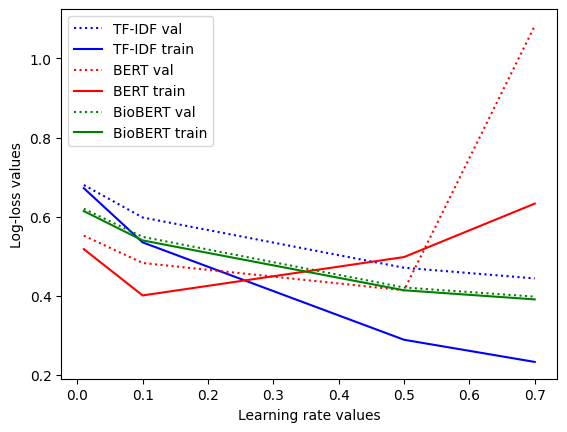

In [57]:
import matplotlib.pyplot as plt

x = [0.01, 0.1, 0.5, 0.7]
y_tfidf = [0.672, 0.535, 0.289, 0.233]
y_bert = [0.518, 0.401, 0.498, 0.633]
y_clinicalbert = [0.614, 0.540, 0.414, 0.391]

y_val_tfidf = [0.680, 0.598, 0.471, 0.444]
y_val_bert = [0.552, 0.483, 0.414, 1.082]
y_val_clinicalbert = [0.620, 0.549, 0.421, 0.398]

plt.plot(x, y_val_tfidf, ':', color='b', label='TF-IDF val')
plt.plot(x, y_tfidf, color='b', label='TF-IDF train')

plt.plot(x, y_val_bert, ':', color='r', label='BERT val')
plt.plot(x, y_bert, '-', color='r', label='BERT train')

plt.plot(x, y_val_clinicalbert, ':', color='g', label='BioBERT val')
plt.plot(x, y_clinicalbert, '-', color='g', label='BioBERT train')


plt.xlabel("Learning rate values")
plt.ylabel("Log-loss values")
plt.legend(loc='upper left')
# plt.title('Average train and validation loss depending on learning rate for FedSGD')
plt.show()

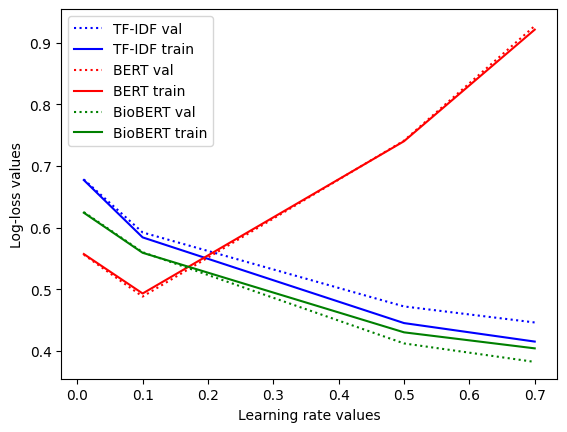

In [58]:
x = [0.01, 0.1, 0.5, 0.7]
y_tfidf = [0.677, 0.584, 0.445, 0.415]
y_bert = [0.557, 0.493, 0.740, 0.921]
y_clinicalbert = [0.624, 0.559, 0.430, 0.404]

y_val_tfidf = [0.678, 0.592, 0.472, 0.446]
y_val_bert = [0.556, 0.488, 0.741, 0.927]
y_val_clinicalbert = [0.625, 0.560, 0.412, 0.382]

plt.plot(x, y_val_tfidf, ':', color='b', label='TF-IDF val')
plt.plot(x, y_tfidf, color='b', label='TF-IDF train')

plt.plot(x, y_val_bert, ':', color='r', label='BERT val')
plt.plot(x, y_bert, '-', color='r', label='BERT train')

plt.plot(x, y_val_clinicalbert, ':', color='g', label='BioBERT val')
plt.plot(x, y_clinicalbert, '-', color='g', label='BioBERT train')


plt.xlabel("Learning rate values")
plt.ylabel("Log-loss values")
plt.legend(loc='upper left')
# plt.title('Average train and validation loss depending on learning rate for FedAvg')
plt.show()